<a href="https://colab.research.google.com/github/kurokykun/onei-notebooks/blob/master/classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación no supervisada de estados de opinión en los Portales Ciudadanos**

Los portales ciudadanos provinciales brindan a la población la posibilidad de hacer diversos planteamientos y recibir retroalimentación por parte de las autoridades pertinentes de cada Govierno Provincial.

A partir de técnicas de scrapping web como se dejó planteado en el anterior [*documento*](https://) se recogieron un grupo importante de planteamientos de diversos tipos sin categoría los cuales se proponen clasificar correctamente a partir de una técnica no supervisada de aprendizaje.



In [290]:
groups = [ 'agua', 'vivienda','comida','política','enseñanza','turismo'] 

## 1. Incrustación de Palabras



Para lo cual estaremos utilizando los conceptos de *word embedding* y *word vectors*.La idea es aprovechar que las clasificaciones que pueden ser dadas a los comentarios son textuales ej:(salud, educacion, electricidad,agua, servicios...etc) y pueden ser proyectados en un espacio vectorial embebido al igual que las palabras q componen el corpus de los comentarios.Por lo tanto, cada comentario se puede clasificar mirando la distancia de su centroide con respecto a cada etiqueta,A lo que me refiero como centroide es al promedio de palabras embebidas que se extraen de los comentarios como se muestra a continuación.

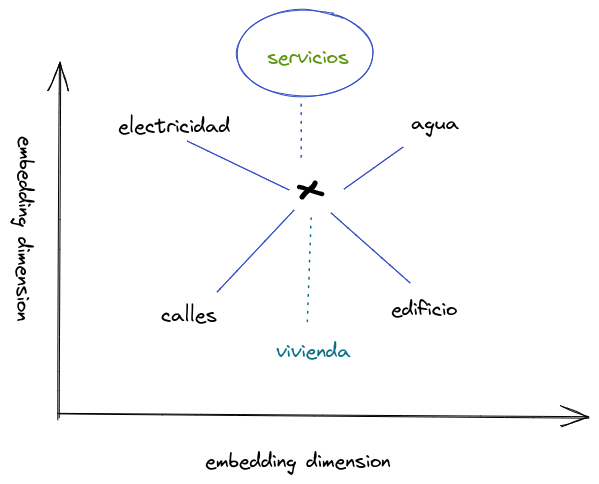



Preparamos en entorno de desarrollo e importamos las librerías que utilizaremos 

In [ ]:
!python -m spacy download es_core_news_md
!apt install python-dev libhunspell-dev
!pip install hunspell
!apt install hunspell-es

import string
from scipy import spatial
import numpy as np
from sklearn import metrics
import requests
import ast
import hunspell
import nltk
from nltk.corpus import stopwords

Cargamos los dátos a utilizar desde el repositorio en github y creamos 

In [219]:
complaints=requests.get('https://raw.githubusercontent.com/kurokykun/digital_gov/master/complaints.json').text
complaints=ast.literal_eval(complaints)
aux_text=[]
for key,values in complaints.items():
  for i in values:
    aux_text.append(i['contenido'])
complaints=aux_text

## 2. Preprocesamiento de los datos y deteccion de outliers




Aplicamos corrección gramatical a los elementos de los comentarios

In [220]:
diccionario = hunspell.HunSpell('/usr/share/hunspell/es_CU.dic','/usr/share/hunspell/es_CU.aff')
codificacion = diccionario.get_dic_encoding()

errores=[]
errores_correg=[]
for i in complaints:
  corregidas=[]
  for j in i.split():
    good=diccionario.spell(j)
    if not good:
      errores.append(j)
      sugerencias = diccionario.suggest(j)
      if len(sugerencias)>0:
        best=sugerencias[0]
        errores_correg.append(best)
        corregidas.append(best)
      else:
        corregidas.append(j)
    else:
      corregidas.append(j)
  complaints[complaints.index(i)]=' '.join(corregidas)


Limpiamos el texto, eliminando símbolos de puntuación, quitando los espacios en blanco innecesarios y volviendo a minúscula todo el texto y eliminando aquellas palabras que son [despreciables](https://github.com/xiamx/node-nltk-stopwords/blob/master/data/stopwords/spanish)

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('spanish')


def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())  # remove multiple whitespaces
    text=' '.join([word for word in text.split() if word not in (stop) and len(word)>2])
    return text


for i in range(len(complaints)):
  complaints[i]=clean_text(complaints[i])

## 3. Configuración del embedding



Procedemos a calcular los centroides de cada una de las palabras de los comentarios

In [267]:
import spacy
nlp = spacy.load('es_core_news_md')


In [268]:
def embed(tokens, nlp):
  lexemes=(nlp.vocab[token] for token in tokens)
  vectors = np.asarray([
          lexeme.vector
          for lexeme in lexemes
      ])
  if len(vectors) > 0:
    centroid = vectors.mean(axis=0)
  else:
    width = nlp.meta['vectors']['width']  # typically 300
    centroid = np.zeros(width)
  return centroid

centroid=embed(complaints[1].split(),nlp)

## 3. Aplicación de K-nn

Finalmente, extraemos los embedding de cada una de las categorías y aplicamos k-nn para determinar la categoría más cercana a la que pertenece.


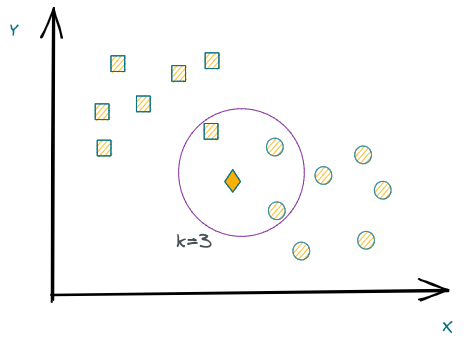

In [ ]:
from sklearn import neighbors

label_vectors = np.asarray([embed(label.split(' '), nlp)for label in groups ])

neigh = neighbors.NearestNeighbors(n_neighbors=1,metric=spatial.distance.cosine)
neigh.fit(label_vectors)

def predict(doc, nlp, neigh):
    doc = clean_text(doc)
    tokens = doc.split(' ')[:50]
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False,)[0][0]
    return closest_label

preds = [groups[predict(comp, nlp, neigh)] for comp in complaints]

## 3. Resultados finales

In [294]:
count={ 'agua':0, 'vivienda':0,'comida':0,'política':0,'enseñanza':0,'turismo':0}
for i in preds:
  count[i]+=1
print(count)

{'agua': 15, 'vivienda': 126, 'comida': 29, 'política': 40, 'enseñanza': 28, 'turismo': 12}
